Business Goal:  Identify which customer regions generate the highest total sales for each product category, month-by-month.

Set up the notebook

In [182]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html, Input, Output


Connect to the SQLite Database

In [183]:
conn = sqlite3.connect(r"C:\Users\beths\Documents\Northwest_Missouri_Analytics\BI_Analytics\smart-store-bethspornitz\data\dw\smart_sales.db")

Preview Tables

In [184]:
# Check table names
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

       name
0  customer
1   product
2      sale


OLAP Query
This query joins the three tables and aggregates total sales by region, category, and month:

In [185]:
query = """
SELECT 
    c.customer_region AS customer_region,
    p.product_category AS product_category,
    strftime('%Y-%m', s.purchase_date) AS sale_month,
    SUM(s.sale_amount_usd) AS total_sales
FROM sale s
JOIN customer c ON s.customer_id = c.customer_id
JOIN product p ON s.product_id = p.product_id
GROUP BY customer_region, product_category, sale_month
ORDER BY customer_region, product_category, sale_month;
"""
df_olap = pd.read_sql(query, conn)


In [186]:
df_line_chart = (
    df_olap.groupby(["customer_region", "sale_month"], as_index=False)
    .agg(total_sales=("total_sales", "sum"))
)

Preview Results

In [187]:
df_olap.head()

,customer_region,product_category,sale_month,total_sales
0,East,Clothing,2024-02,1318.10
1,East,Clothing,2024-05,117.30
2,East,Clothing,2024-06,387.90
3,East,Clothing,2024-07,694.34
4,East,Clothing,2024-08,1263.90


Bar Plot: Total Sales by Region and Product Category


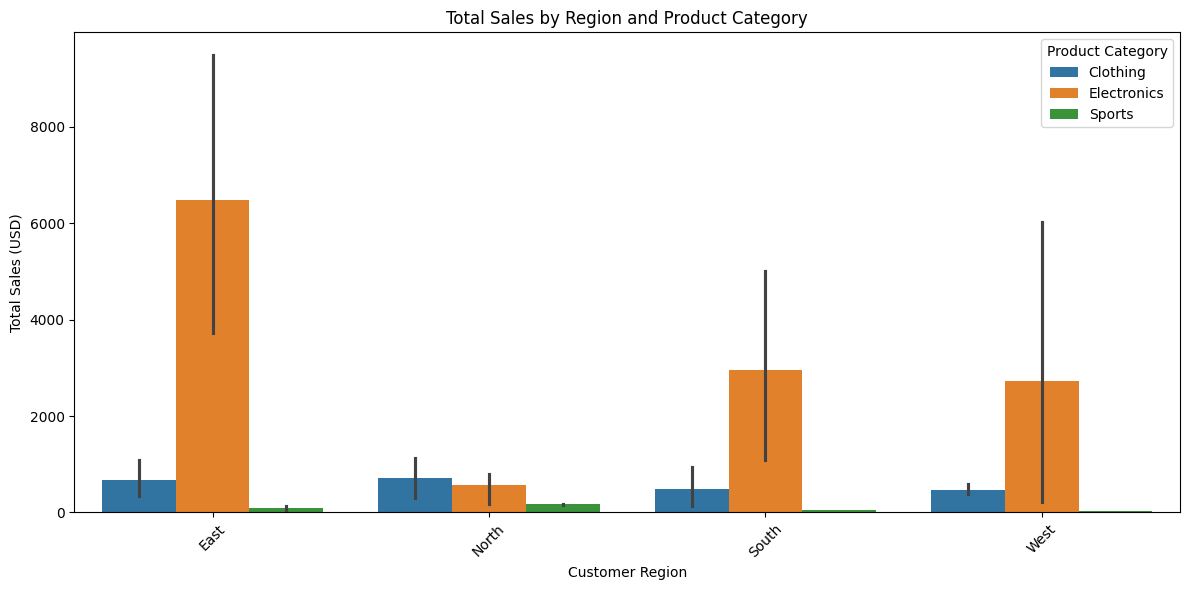

In [188]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_olap, x="customer_region", y="total_sales", hue="product_category")
plt.title("Total Sales by Region and Product Category")
plt.ylabel("Total Sales (USD)")
plt.xlabel("Customer Region")
plt.legend(title="Product Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Line Chart: Sales Trends by Month (Faceted by Region)

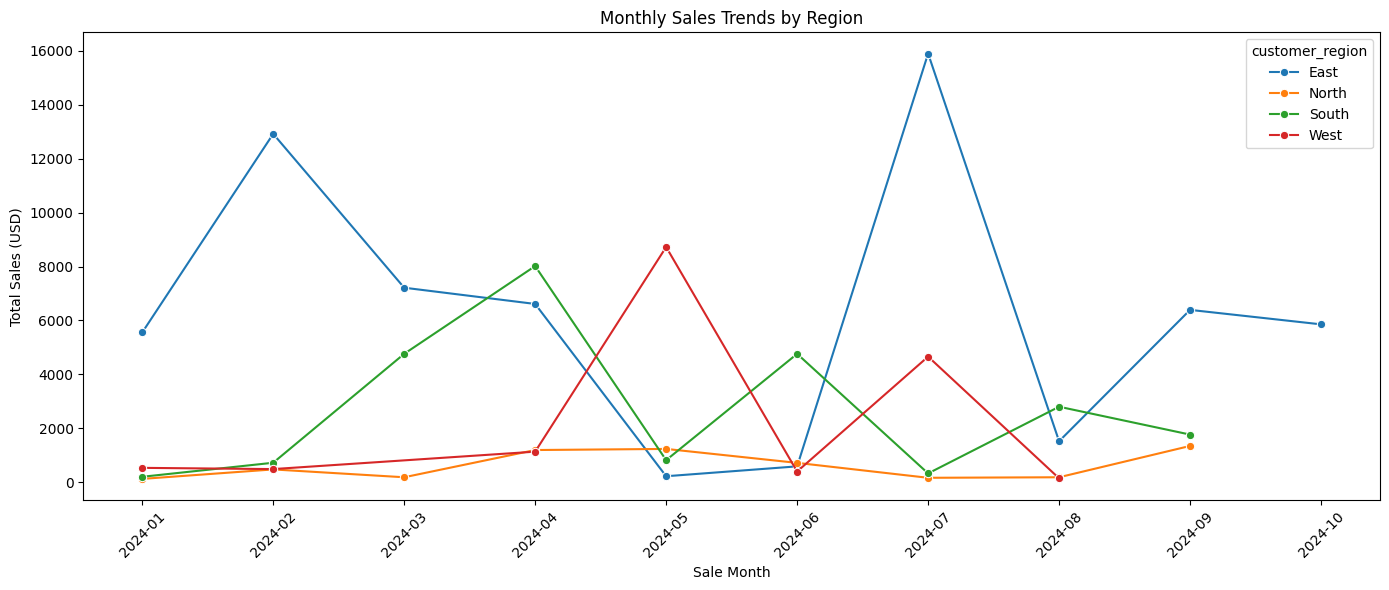

In [189]:
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=df_line_chart,
    x="sale_month",
    y="total_sales",
    hue="customer_region",
    marker="o"
)
plt.title("Monthly Sales Trends by Region")
plt.xticks(rotation=45)
plt.ylabel("Total Sales (USD)")
plt.xlabel("Sale Month")
plt.tight_layout()
plt.show()

Heatmap: Region vs Product Category by Total Sales

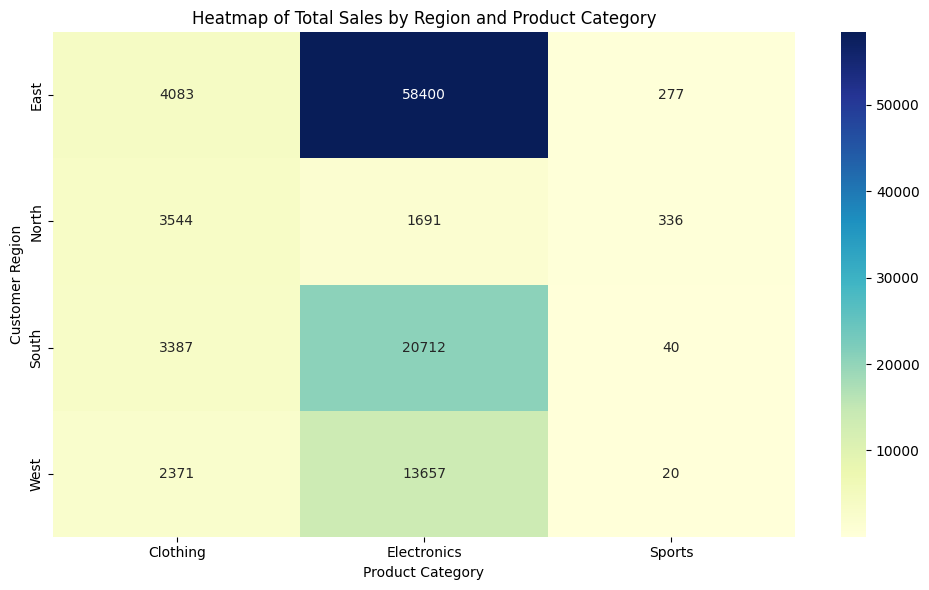

In [190]:
heatmap_data = df_olap.pivot_table(
    index="customer_region", 
    columns="product_category", 
    values="total_sales", 
    aggfunc="sum", 
    fill_value=0
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Heatmap of Total Sales by Region and Product Category")
plt.ylabel("Customer Region")
plt.xlabel("Product Category")
plt.tight_layout()
plt.show()

Interactive Bar Chart: Total Sales by Region and Product Category

In [191]:
fig = px.bar(
    df_olap,
    x="customer_region",
    y="total_sales",
    color="product_category",
    barmode="group",
    title="Total Sales by Region and Product Category",
    labels={"customer_region": "Customer Region", "total_sales": "Total Sales (USD)"}
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

Interactive Line Chart: Monthly Sales Trend by Region

In [192]:
# Step 1: Aggregate your data for the line chart
df_line_chart = (
    df_olap.groupby(["customer_region", "sale_month"], as_index=False)
    .agg(total_sales=("total_sales", "sum"))
)

# Step 2: Plot it using Plotly
fig = px.line(
    df_line_chart,
    x="sale_month",
    y="total_sales",
    color="customer_region",
    markers=True,
    title="Monthly Sales Trends by Region",
    labels={"sale_month": "Sale Month", "total_sales": "Total Sales (USD)"}
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

Interactive Faceted Line Chart: Monthly Sales by Product Category

In [193]:
fig = px.line(
    df_olap,
    x="sale_month",
    y="total_sales",
    color="customer_region",
    facet_col="product_category",
    facet_col_wrap=3,
    title="Monthly Sales by Product Category and Region",
    markers=True,
    labels={"sale_month": "Month", "total_sales": "Total Sales (USD)"}
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [194]:
df = df_olap.copy()

# Create the app
app = Dash(__name__)

# App layout
app.layout = html.Div([
    html.H1("Monthly Sales Trends by Region and Product Category", style={
        'textAlign': 'center', 'margin': '20px', 'color': '#333'
    }),
    
    html.Div([
        html.Label("Select Customer Region:"),
        dcc.Dropdown(
            id='region-dropdown',
            options=[{'label': region, 'value': region} for region in sorted(df['customer_region'].unique())],
            value=sorted(df['customer_region'].unique())[0],
            clearable=False
        )
    ], style={'width': '45%', 'margin': '0 auto 20px auto'}),
    
    html.Div([
        html.Label("Select Product Category:"),
        dcc.Dropdown(
            id='category-dropdown',
            options=[{'label': cat, 'value': cat} for cat in sorted(df['product_category'].unique())],
            value=sorted(df['product_category'].unique())[0],
            clearable=False
        )
    ], style={'width': '45%', 'margin': '0 auto 20px auto'}),

    dcc.Graph(id='sales-line-chart', style={'backgroundColor': '#fff', 'padding': '10px'})
], style={
    'backgroundColor': '#f9f9f9',
    'padding': '20px'
})

# Callback for interactivity
@app.callback(
    Output('sales-line-chart', 'figure'),
    Input('region-dropdown', 'value'),
    Input('category-dropdown', 'value')
)
def update_chart(region, category):
    filtered_df = df[
        (df['customer_region'] == region) &
        (df['product_category'] == category)
    ]

    fig = px.line(
        filtered_df,
        x='sale_month',
        y='total_sales',
        markers=True,
        title=f"Monthly Sales in {region} for {category}"
    )

    fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(color='black'),
        xaxis_title="Month",
        yaxis_title="Total Sales (USD)"
    )

    return fig

# Run in notebook (or just app.run(debug=True) if in a script)
app.run(debug=True)

In [196]:
import sqlite3
import pandas as pd
import plotly.express as px
from dash import Dash, html, dcc, Input, Output


df = pd.read_sql_query(query, conn)
df["sale_month"] = pd.to_datetime(df["sale_month"])

# ✅ Create Dash app
app = Dash(__name__)

# ✅ Layout
app.layout = html.Div([
    html.H1(
        "Sales Trends by Region and Product Categories",
        style={
            'textAlign': 'center',
            'color': '#333',
            'backgroundColor': '#f9f9f9',
            'padding': '20px',
            'marginBottom': '30px'
        }
    ),

    html.Div([
        html.Label("Select Product Categories:"),
        dcc.Dropdown(
            id='category-dropdown',
            options=[{'label': cat, 'value': cat} for cat in sorted(df['product_category'].unique())],
            value=list(df['product_category'].unique()),
            multi=True,
            clearable=False
        )
    ], style={'width': '60%', 'margin': 'auto'}),

    html.Div([
        html.Label("Select Date Range:"),
        dcc.DatePickerRange(
            id='date-picker-range',
            min_date_allowed=df['sale_month'].min(),
            max_date_allowed=df['sale_month'].max(),
            start_date=df['sale_month'].min(),
            end_date=df['sale_month'].max()
        )
    ], style={'width': '60%', 'margin': 'auto', 'padding': '20px'}),

    dcc.Graph(id='line-chart')
], style={'backgroundColor': '#ffffff', 'padding': '10px'})

# ✅ Callback logic
@app.callback(
    Output('line-chart', 'figure'),
    Input('category-dropdown', 'value'),
    Input('date-picker-range', 'start_date'),
    Input('date-picker-range', 'end_date')
)
def update_chart(selected_categories, start_date, end_date):
    filtered_df = df[
        (df['product_category'].isin(selected_categories)) &
        (df['sale_month'] >= pd.to_datetime(start_date)) &
        (df['sale_month'] <= pd.to_datetime(end_date))
    ]

    fig = px.line(
        filtered_df,
        x='sale_month',
        y='total_sales',
        color='customer_region',
        line_group='product_category',
        markers=True,
        title="Sales Trends by Region and Selected Product Categories",
        labels={'sale_month': 'Month', 'total_sales': 'Total Sales (USD)'}
    )

    fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(color='black'),
        xaxis_title="Month",
        yaxis_title="Total Sales (USD)"
    )

    return fig

# ✅ Run app
if __name__ == "__main__":
    app.run(debug=True, port=8051)
